# Quail segmentation and feature extraction exploration #

*9 January 2023*

Based on `Segmentation_01.ipyb` from co-coding with Robert Haase last week.

I'd like the full workflow in Jupyter; then add exploration with other background de-noising or sklearn Random Forest Segmentation.

## Import tools ##

In [1]:
import napari
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.3
import napari_crop
import pyclesperanto_prototype as cle  # version 0.21.2
import pandas as pd

from napari_simpleitk_image_processing import label_statistics
from skimage.io import imread, imsave

import napari_skimage_regionprops as nsr

from sklearn.preprocessing import StandardScaler
import seaborn
import stackview

## Set filenames ##

In [46]:
source_stack          = '/Volumes/Quail/Quail/220214_highresnode/220214_63x_node_scan_121t_11x11y_MERGED_rotated.tif'
datafolder            = 'data/'
cropped_node_file     = f'{datafolder}220214_cropped_node.tif'
cropped_non_node_file = f'{datafolder}220214_cropped_non_node.tif'

## Open viewer ##

In [3]:
viewer = napari.Viewer()

## Add source stack ##

In [4]:
# viewer.open('/Volumes/Quail/Quail/220214_highresnode/220214_63x_node_scan_121t_11x11y_MERGED_rotated.tif')
highres_node = imread(source_stack)

In [5]:
viewer.add_image(
    highres_node,
    colormap='gray_r'
)

<Image layer 'highres_node' at 0x168c9cfa0>

## Define crop regions ##

One in Henson's node, the other in the periphery of the tissue.

In [6]:
node_crop_region = [
    [100, 6359.53378526, 6166.86457369],
    [100, 6359.53378526, 8045.70961167],
    [100, 8238.37882323, 8045.70961167],
    [100, 8238.37882323, 6166.86457369]
]

In [7]:
non_node_crop_region = [
    [   67.        ,  6606.34456304, 10653.08839096],
    [   67.        ,  6606.34456304, 12536.25288005],
    [   67.        ,  8489.50905213, 12536.25288005],
    [   67.        ,  8489.50905213, 10653.08839096]
]

In [8]:
viewer.add_shapes(
    node_crop_region,
    name='node_crop_region',
    opacity=0.5,
    ndim=3,
)

<Shapes layer 'node_crop_region' at 0x17a0ce920>

In [9]:
viewer.add_shapes(
    non_node_crop_region,
    name='non_node_crop_region',
    opacity=0.5,
    ndim=3,
)

<Shapes layer 'non_node_crop_region' at 0x140262d70>

In [10]:
viewer.layers

[<Image layer 'highres_node' at 0x168c9cfa0>, <Shapes layer 'node_crop_region' at 0x17a0ce920>, <Shapes layer 'non_node_crop_region' at 0x140262d70>]

## Crop ##

Uses napari_crop plugin.

In [11]:
cropped_node = napari_crop.crop_region(layer=viewer.layers[0], shapes_layer=viewer.layers[1])[0][0] # cropped node returnds a list of [(data, metadata_dictionary)] tuples for each shape
cropped_node.shape

(201, 1879, 1880)

In [12]:
cropped_non_node = napari_crop.crop_region(layer=viewer.layers[0], shapes_layer=viewer.layers[2])[0][0] # cropped node returnds a list of [(data, metadata_dictionary)] tuples for each shape
cropped_non_node.shape

(201, 1885, 1884)

## View cropped regions ##

In [13]:
viewer.add_image(
    cropped_node,
    colormap='gray_r'
)

<Image layer 'cropped_node' at 0x1403ebe20>

In [14]:
viewer.add_image(
    cropped_non_node,
    colormap='gray_r'
)

<Image layer 'cropped_non_node' at 0x1403511b0>

## Save cropped regions ##

In [15]:
imsave(cropped_node_file, cropped_node, plugin='tifffile')

In [16]:
imsave(cropped_non_node_file, cropped_non_node, plugin='tifffile')

## Close unneeded layers ##

Free up memory.

In [17]:
viewer.layers.remove('highres_node')

In [18]:
viewer.layers.remove('node_crop_region')

In [19]:
viewer.layers.remove('non_node_crop_region')

In [20]:
viewer.layers.remove('cropped_node')

In [21]:
viewer.layers.remove('cropped_non_node')

## Scale 3D data ##

Allows exploration on local mac (M1 or Intel)

In [22]:
voxel_size_xy = 1
voxel_size_z  = 5     # according to Adrian the pixels in this dataset are isotropic
zoom          = 0.25 

cl.OCLArray([[[ 4.,  0.,  0., ...,  0.,  4., 16.],
        [ 0., 36., 26., ...,  0.,  0.,  5.],
        [29.,  0., 15., ...,  4., 14.,  0.],
        ...,
        [11.,  0., 11., ...,  6.,  6.,  0.],
        [ 6.,  1.,  0., ..., 23.,  0.,  4.],
        [19., 12., 18., ...,  0.,  8.,  0.]],

       [[11.,  6., 12., ...,  3.,  0., 10.],
        [ 3.,  0.,  0., ..., 13., 24., 10.],
        [ 0., 36.,  3., ...,  0.,  6., 12.],
        ...,
        [ 0.,  0., 13., ...,  7.,  2.,  0.],
        [ 0.,  7., 10., ...,  0., 10.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0., 14., 17., ..., 15.,  0.,  4.],
        [ 8.,  0., 25., ...,  1.,  0.,  0.],
        [ 0.,  0.,  1., ..., 53.,  1.,  0.],
        ...,
        [ 2., 21.,  0., ...,  0.,  0.,  5.],
        [ 0.,  0.,  8., ...,  0.,  0.,  0.],
        [ 7.,  0.,  0., ...,  0.,  5.,  5.]],

       ...,

       [[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  3.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  5.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 12.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [10.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
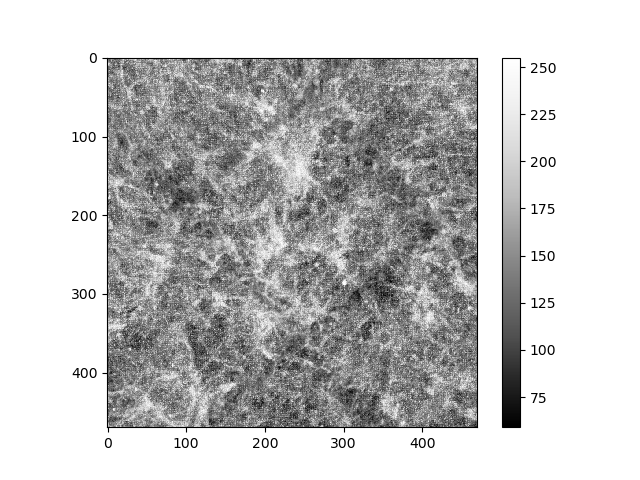
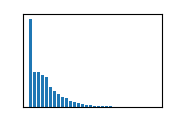

In [23]:
cropped_node_scaled = (
    cle.scale(
        cropped_node, 
        factor_x=voxel_size_xy*zoom, 
        factor_y=voxel_size_xy*zoom, 
        factor_z=voxel_size_z*zoom, 
        auto_size=True,
        # linear_interpolation=True # linear interpolation not supported on intel cpu
    ) 
)
cropped_node_scaled

In [24]:
cropped_node_scaled_layer = (
    viewer.add_image(
        cropped_node_scaled, 
        colormap='gray_r',
        interpolation3d='bicubic',
        contrast_limits=[0,255],
    )
)

## Local minima seeded watershed in 3D ##

Uses 3D data.  Local minima are regions between membranes as seed.

```
Segment cells in images with fluorescently marked membranes.
    The two sigma parameters allow tuning the segmentation result. The first sigma controls how close detected cells
    can be (spot_sigma) and the second controls how precise segmented objects are outlined (outline_sigma). Under the
    hood, this filter applies two Gaussian blurs, local minima detection and a seeded watershed.
    See also
    --------
    .. [1] https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
```

In [25]:
# Robert suggested 25 and 5 for the spot sigma and outline sigmas
# By my eye, 30 and 10 are a bit better
lmsw_3d = nsbatwm.local_minima_seeded_watershed(cropped_node_scaled, 30*zoom, 10.0*zoom)

In [26]:
# lmsw_labels = viewer_3d.add_labels(lmsw_3d)

In [27]:
# exclude labels on the edge of the stack
exclude_labels_on_edges = cle.exclude_labels_on_edges(lmsw_3d)
# viewer.add_labels(
#     exclude_labels_on_edges, name='Result of exclude_labels_on_edges (clesperanto)')

In [28]:
# exclude small labels
exclude_small_labels = cle.exclude_small_labels(exclude_labels_on_edges, None, 100.0) # base small on zoom in future
# viewer.add_labels(
#     exclude_small_labels, name='Result of exclude_small_labels (clesperanto)')

In [29]:
labels_3d_layer = (
    viewer.add_labels(
        exclude_small_labels,
        opacity=0.5,
    )
)

## Empirically vary watershed sigmas ##

In [32]:
spot_sigmas = [10, 20, 30, 40, 50]
outline_sigmas = [5, 7, 10, 12]
# spot_sigmas = [30]
# outline_sigmas = [10]

In [31]:
for ss in spot_sigmas:
    for os in outline_sigmas:
        
        lmsw_3d = nsbatwm.local_minima_seeded_watershed(cropped_node_scaled, ss*zoom, os*zoom)
        exclude_labels_on_edges = cle.exclude_labels_on_edges(lmsw_3d)
        exclude_small_labels = cle.exclude_small_labels(exclude_labels_on_edges, None, 100.0) # base small on zoom in future
        viewer.add_labels(exclude_small_labels, name=f'spot{ss:02}_outline{os:02}', opacity=0.5)

In [35]:
viewer.layers[2]

<Labels layer 'spot10_outline05' at 0x15f649660>

## Save watershed segmentation layers ##

In [53]:
datafolder = 'data/'
for layer in viewer.layers[1:]:
    filename = f'{datafolder}{layer.name}.tif'
    print(f'Saving... {filename}')
    data = layer.data
    imsave(filename, data, plugin='tifffile')
    # layer.save(filename)

Saving... data/exclude_small_labels.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/exclude_small_labels.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot10_outline05.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot10_outline05.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot10_outline07.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot10_outline07.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot10_outline10.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot10_outline10.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot10_outline12.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot10_outline12.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot20_outline05.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot20_outline05.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot20_outline07.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot20_outline07.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot20_outline10.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot20_outline10.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot20_outline12.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot20_outline12.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot30_outline05.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot30_outline05.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot30_outline07.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot30_outline07.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot30_outline10.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot30_outline10.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot30_outline12.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot30_outline12.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot40_outline05.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot40_outline05.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot40_outline07.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot40_outline07.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot40_outline10.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot40_outline10.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot40_outline12.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot40_outline12.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot50_outline05.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot50_outline05.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot50_outline07.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot50_outline07.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot50_outline10.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot50_outline10.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


Saving... data/spot50_outline12.tif


/var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/ipykernel_3403/917551268.py:6: UserWarning: data/spot50_outline12.tif is a low contrast image
  imsave(filename, data, plugin='tifffile')


## Vary voxel_size_z ## 

To examine the effect of scaling on watershed

In [22]:
voxel_size_xy = 1
voxel_size_z  = 5     # according to Adrian the pixels in this dataset are isotropic
zoom          = 0.25 

In [1]:
voxel_size_z  = [1,2,3,4,5,6] 

for z in voxel_size_z:
    cropped_node_scaled     = cle.scale( cropped_node, factor_x=voxel_size_xy*zoom, factor_y=voxel_size_xy*zoom,  factor_z=voxel_size_z*zoom,  auto_size=True,) # linear_interpolation=True # linear interpolation not supported on intel cpu
    
    lmsw_3d = nsbatwm.local_minima_seeded_watershed(cropped_node_scaled, 30*zoom, 10.0*zoom)
    
    exclude_labels_on_edges = cle.exclude_labels_on_edges(lmsw_3d)
    exclude_small_labels    = cle.exclude_small_labels(exclude_labels_on_edges, None, 100.0) # base small on zoom in future
    
    viewer.add_labels(exclude_small_labels, name=f'watershed_z_scale{z}', opacity=0.5)
    
    data                   = viewer.layers[-1].data
    filename               = f'{datafolder}{viewer.layers[-1].name}.tif'
    
    print(f'Saving... {filename}')
    imsave(filename, data, plugin='tifffile')

NameError: name 'cle' is not defined